# Supplementary code for  *Integral equation methods for acoustic scattering by fractals*

This notebook contains sample code which can be used to reproduce the field plots in Section 5(a) of the Proc. R. Soc. paper **Integral equation methods for acoustic scattering by fractals**, by *A. M. Caetano, S. N. Chandler-Wilde, X. Claeys, A. Gibbs, D. P. Hewett and A. Moiola*.

All results in the above paper were produced using the open-source Julia package [IFSintegrals](https://github.com/AndrewGibbs/IFSintegrals). A technical understanding of this package is **not** required to understand the key ideas in this notebook. Throughout this notebook, we will make frequent references to equation numbers of the associated paper.

### Setting up the problem
First, we load the relevant Julia packages.

In [1]:
using IFSintegrals, Plots, LinearAlgebra;
import IFSintegrals: rotation2

Next, define the scatterer. Most of the examples considered are available as presets in ```IFSintegrals```. The variable ```eg_index``` determines which example to run. 

In [2]:
eg_index = 1;

The following values of ```eg_index``` correspond to different scattering configurations, each in $\mathbb{R}^2$:
1. The Koch curve (see Example 2.3)
2. Cantor set  with contraction factor $\rho=1/3$
3. Cantor dust with contraction factor $\rho=1/3$
4. A Koch snowflake, constructed as the union of three Koch curves (see Fig. 8(b))
5. The union of a Cantor set with contraction factor $\rho=1/3$ and a Koch curve.

Now we define our scatterer $\Gamma$ and plot it.

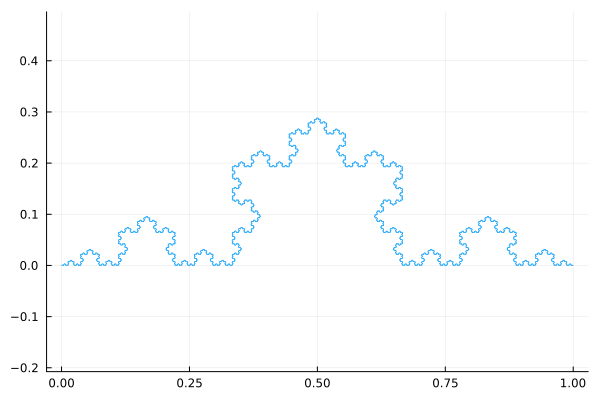

In [3]:
if eg_index == 1 # Koch curve
    Γ = KochCurve()
elseif eg_index == 2 # Cantor dust
    Γ = CantorSet() + [0,0]
elseif eg_index == 3 # Cantor set
    Γ = CantorDust()
elseif eg_index == 4 # Koch snowflake, as a union of Koch curves
    Koch_height = 0.288675134594813
    γ = KochCurve()+[-1/2,Koch_height]
    γ₁ = γ
    γ₂ = rotation2(2π/3)*γ
    γ₃ = rotation2(4π/3)*γ
    Γ = UnionInvariantMeasure([γ₁,γ₂,γ₃])
elseif eg_index == 5 # Cantor set union Koch curve
    γ₁ = CantorSet() + [0,-0.2] # embed Cantor set in ℝ² and translate
    γ₂ = KochCurve()
    Γ = UnionInvariantMeasure([γ₁, γ₂])
end

# now plot the fractal
plot(Γ, aspect_ratio=1, legend=false, markersize=0.5)

We note that for cases ```eg_index```$=4,5$, we are translating the fractals by adding a vector, and ```eg_index```$=4$ also has a rotation. By default, the Cantor set is defined as a subset of $\mathbb{R}$. By adding $[0,0]$ in line 4 (similarly in line 15), the Cantor set is embedded in $\mathbb{R}^2$.

Now we define an incident plane wave $u^i(x):=\mathrm{e}^{\mathrm{i}k\vartheta\cdot x}$:

In [4]:
k = 20.0 # wavenumber
ϑ = [1, 1]/sqrt(2) # incident direction
uⁱ(x) = exp(im*k*(ϑ⋅x)) 
g(x) = -uⁱ(x)

g (generic function with 1 method)

In the final line above, we construct the right-hand side data (3.6).

### Approximating the solution

Now define the approximation parameters $h$ and $h_Q$. Choosing smaller values will make the solution more accurate, but will make the coder take longer.

In [5]:
h = 0.05 # max mesh width of BEM elements
hQ = 0.01; # max mesh width for quadrature in BEM

Define the boundary integral operator $A$ of (3.15), and its discretised stucture $A_h$, which contains essential information about the mesh, Galerkin matrix (4.16), etc. Then solve the system to obtain the discrete solution $\phi_h$.

In [6]:
A = SingleLayerOperatorHelmholtz(Γ, k) # Single layer operator defined on screen Γ, with wavenumber k
Aₕ = DiscreteSIO(A; h_mesh = h, h_quad = hQ)
ϕ_N = Aₕ\g;

The final line above represents the Galerkin system (4.15). Now we can construct an approximation to the total field using (3.14) and (3.10):

In [7]:
𝘈ϕ_N = SingleLayerPotentialHelmholtz(ϕ_N,k; h_quad = hQ)# returns function
u_N(x) = uⁱ(x) + 𝘈ϕ_N(x) # total field

u_N (generic function with 1 method)

### Plotting the total field

Now we create a box in which we will plot our solution. The variable ```Npixels``` determines the resolution, if this is increased then the code will take longer.

In [8]:
Npixels = 150;
box_xlims = [-1,2] # horizontal limits of box
box_ylims = [-1,1]; # vertical limits of box

In [9]:
h□x = (box_xlims[2]-box_xlims[1])/Npixels
h□y = (box_ylims[2]-box_ylims[1])/Npixels
x₁ = box_xlims[1]:h□x:box_xlims[2]
x₂ = box_ylims[1]:h□y:box_ylims[2]
X = [[x₁_,x₂_] for x₁_∈x₁, x₂_∈x₂];

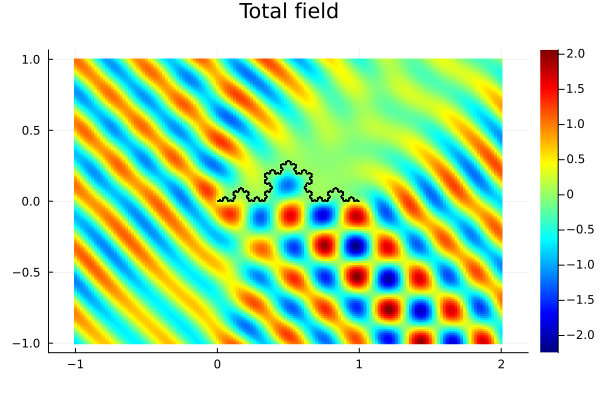

In [10]:
heatmap(x₁,x₂,transpose(real(u_N.(X))), aspect_ratio = 1, 
    title="Total field", label=false, c = :jet)
plot!(Γ,color = "black", markersize=0.5, label=false)